In [44]:
import sys
sys.path.insert(0, '../') 
import datastructure
import geopandas
import numpy
import pyhdf.SD
import math
import shapely
import matplotlib.pyplot as plt

In [45]:
# Load the polygon
polygons = geopandas.read_file('data/santa_barbara.gpkg') 

geom = polygons.iloc[0].geometry[0]
polygon = datastructure.SphericalPolygon(geom)

In [46]:
polygon.get_convex()

In [47]:
# Loading granule
fname = 'data/MOD09.A2020032.1940.006.2020034015024.hdf'
hdf = pyhdf.SD.SD(fname)
lat = hdf.select('Latitude').get().flatten()
lon = hdf.select('Longitude').get().flatten()

x = numpy.cos(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
y = numpy.sin(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
z = numpy.sin(lat/360*math.pi*2)

points = numpy.array([x, y, z]).transpose()

In [53]:
# Getting Candidates
dots = numpy.einsum('ji,mi->jm', points, polygon.convex_edges.gcs)
n_constraints = len(polygon.convex_edges.gcs)
inside_convex = numpy.where(numpy.sum(dots>0, axis=1)==n_constraints)[0]
candidate_points = points[inside_convex]

array([430545, 430546, 430547, ..., 542928, 544279, 544280])

In [42]:
convex_points = []
for j_i in inside_convex:
    convex_points.append(shapely.geometry.Point(lon[j_i], lat[j_i]))
convex_points = geopandas.GeoDataFrame({'geom': convex_points}).set_geometry('geom')

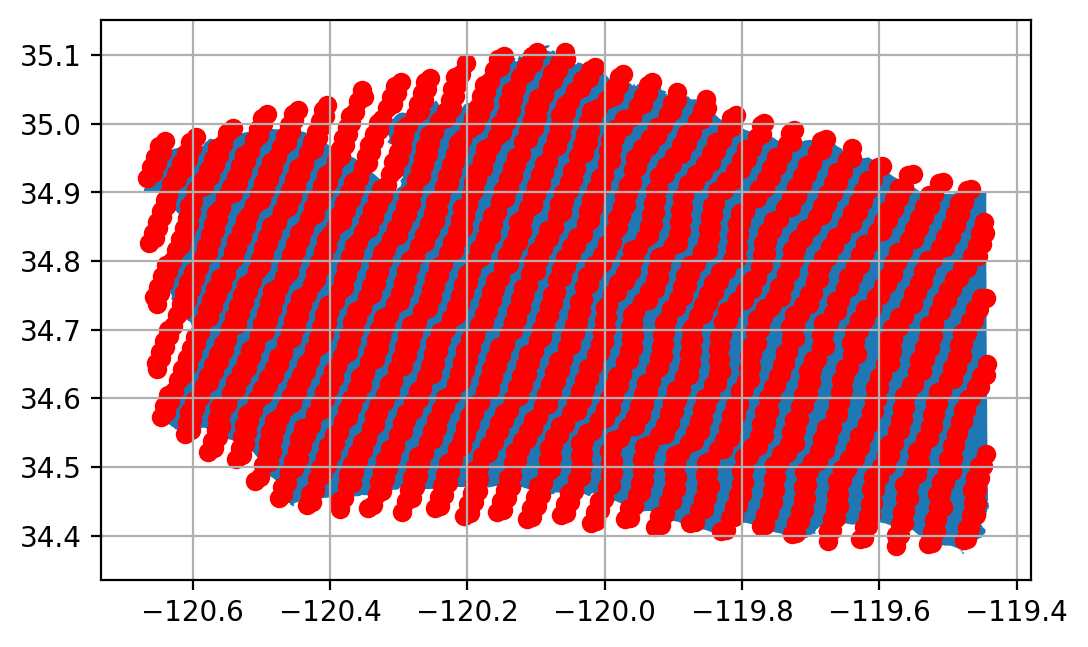

In [43]:
fig, ax = plt.subplots(dpi=200)
ax.grid(True)

polygons.plot(ax=ax)
convex_points.plot(ax=ax, color='r')

In [64]:
def outbound_intersect(ray, point, gc, lim1, lim2):
    ray_intersect = numpy.cross(gc, ray)
    crosses = (numpy.dot(ray_intersect, lim1)  *  
               numpy.dot(ray_intersect, lim2)) > 0     
    if not crosses:
        return 0
    else: 
        crossing_direction = numpy.dot(point, gc)        
        if crossing_direction < 0:
            return 1
        else:
            return -1


ray_dest = numpy.array([0, 0, 1])
def inside_polygon_np(point):
    ray = numpy.cross(point, ray_dest)
    net_out = 0
    for n in range(len(polygon.edges.gcs)-1):
        net_out += outbound_intersect(ray, 
                                      point, 
                                      polygon.edges.gcs[n], 
                                      polygon.edges.left_gcs[n], 
                                      polygon.edges.right_gcs[n])
    
    if net_out > 0:
        return True
    else:
        return False

In [126]:
def inside_polygon_np(point):
    ray_dest = numpy.array([0, 0, 1])

    ray = numpy.cross(point, ray_dest)
    intersects = numpy.cross(polygon.edges.gcs, ray)
    left = numpy.einsum('ij,ij->i', intersects, polygon.edges.left_gcs)
    right = numpy.einsum('ij,ij->i', intersects, polygon.edges.right_gcs)
    crossings_gc = polygon.edges.gcs[left*right > 0]
    return sum(numpy.dot(crossings_gc, point)>0)<=0

In [133]:
polygon_points = []
i = 0
for point in candidate_points:        
    if inside_polygon_np(point):
        polygon_points.append(i)    
    i+=1

In [134]:
inside_convex[numpy.array(polygon_points)]

array([430545, 431899, 431900, ..., 537509, 542925, 542926])

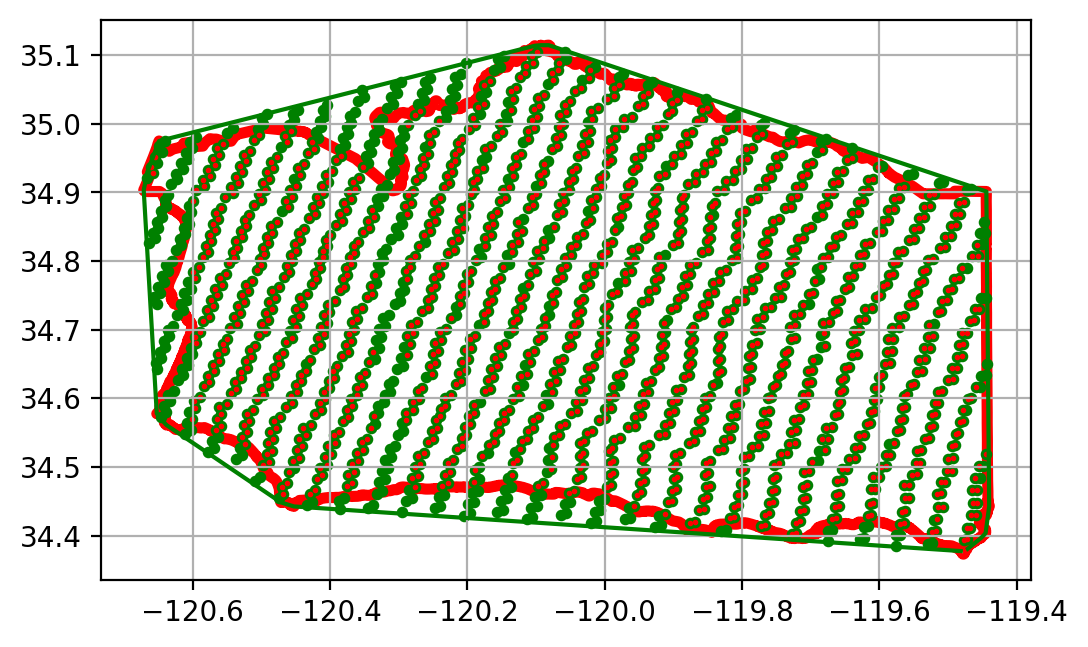

In [140]:
fig, ax = plt.subplots(dpi=200)
ax.grid(True)



points_convex = []
for j in inside_convex:
    points_convex.append(shapely.geometry.Point(lon[j], lat[j]))
points_convex = geopandas.GeoDataFrame({'geom': points_convex}).set_geometry('geom')


points_poly = []
for j in inside_convex[numpy.array(inside_polygon)]:
    points_poly.append(shapely.geometry.Point(lon[j], lat[j]))
points_poly = geopandas.GeoDataFrame({'geom': points_poly}).set_geometry('geom')

polygon.convex_nodes.as_line_df().plot(ax=ax, color='green')
polygons.plot(ax=ax, color='white', edgecolor='red', linewidth=4)
points_convex.plot(ax=ax, color='green', markersize=10)
points_poly.plot(ax=ax, color='red', markersize=1)